# Лабораторная работа №2
## "PySpark ML"
### вариант 2
### Лукин А.В.

#### Цель работы: Напишите программу на PySpark согласно вашему варианту для датасета “DS_2019_public.csv”.
В отчёте обязательно должно быть описание выбранных признаков, предсказываемых признаков/категорий, почему вы сделали такой выбор и выведена точность работы полученной модели. Если точность модели получилась невысокой, внесите изменения в выбор признаков, чтобы повысить точность, и отобразите это в отчёте.

### Задание: Напишите программу, реализующую модель логистической регрессии. Выберите несколько количественных признаков (не менее 5). Предсказывайте одну из категорий Climate_Region_Pub – установите одну из категорий согласно вашему варианту задания на 1, а все остальные – на 0.


In [1187]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [1188]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

In [1189]:
from pyspark.sql.functions import when, count, isnull, percentile_approx
import pyspark.sql.functions as f

In [1190]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Прочитаем документ: DS_2019_public.csv.
* header - заголовок
* inferSchema - параметр, для определения типа данных в столбцах (str, int, double)

In [1191]:
df = spark.read.csv('DS_2019_public.csv', header=True, inferSchema=True)
df

Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,CELLAR,NWEIGHT,TOTHSQFT,HEATHOME,NUMPC,DOLLAREL,DOLELOTH,CUFEETNGSPH,BTUNGSPH,DOLNGSPH,TEMPHOME,TOTCSQFT,BTUFOSPH,AIRCOND,ELCOOL,GALLONFOSPH,WALLTYPE,TOTALDOLOTH,BTUFO,GALLONFO,DOLFOSPH,DOLLARFO,KWHSPH,BTUELSPH,FOWARM,USEFO,TOTUSQFT,TOTALDOL,NUMTHERM,DOLELSPH,CONCRETE,CUFEETNG,BTUNG,GALLONFOOTH,BTUFOOTH,BEDROOMS,FOWATER,GALLONFOWTH,BTUFOWTH,DOLFOWTH,GALLONKEROTH,BTUKEROTH,DOLKEROTH,TOTUCSQFT,TOTSQFT,TOTSQFT_EN,DOLNGWTH,DOLFOOTH,ELOTHER,DOLLARNG,FUELHEAT,NOTMOIST,GALLONKER,BTUKER,NUMCFAN,FOILAUX,TOTALBTU,COOLTYPE,DOOR1SUM,DOLLARKER,DOLLPOTH,DOLELWTH,KWHWTH,BTUELWTH,TOTROOMS,ELWATER,GALLONKERSPH,BTUKERSPH,TOTALBTUOTH,GALLONLPSPH,BTULPSPH,NCOMBATH,OVEN,EQUIPM,STORIES,GALLONLP,BTULP,LGT1,SOLWARM,FUELH2O,GALLONLPOTH,BTULPOTH,TVCOLOR,SOLARAUX,CUFEETNGOTH,BTUNGOTH,KWHOTH,DOLKERSPH,TOTALDOLWTH,DOLLPSPH,USENG,YEARMADE,BTUELOTH,KWH,BTUEL,DOLLARLP,CUFEETNGWTH,BTUNGWTH,UGWATER,SDESCENT,TEMPGONE,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
5,10,26,16.793,17,181.998,620.979,621,368,38606,0,8599.17201,2736,1,2,475,337.315,376.643,38605.955,367.654,70,2736,0.0,1,1,0.0,2,501,0,0,0,0,0.0,0.0,0,0,400,1293,1,0,0,838,85895,0.0,0.0,3,0,0.0,0.0,0.0,0,0.0,0.0,400,3136,2736,286.745,0.0,1,818,1,0,0,0,0,0,103460,1,0,0,0.0,0.0,0.0,0.0,4,0,0,0.0,29653,0.0,0.0,2,0,3,31,0,0,0,0,1,0.0,0.0,2,0,167.601,17179.073,3655.782,0.0,287,0.0,1,1998,12473.544,5148,17565,0,293.756,30109.973,1,0,70,-2,30110,2,120.893,121,4,0,1,1,1310.22
1,1,1,48.901,49,184.459,629.389,629,582,40248,-2,8969.915921,528,1,1,588,296.353,392.662,40248.226,581.517,68,264,0.0,1,1,0.0,1,339,0,0,0,0,0.0,0.0,0,0,0,1327,1,0,-2,499,51148,0.0,0.0,1,0,0.0,0.0,0.0,0,0.0,0.0,264,528,528,114.618,0.0,1,739,1,0,0,0,1,0,58716,2,0,0,0.0,0.0,0.0,0.0,2,0,0,0.0,6781,0.0,0.0,1,0,2,-2,0,0,2,0,1,0.0,0.0,1,0,28.944,2966.796,1117.878,0.0,115,0.0,1,1965,3814.291,2218,7568,0,77.394,7932.978,1,0,60,2,7933,-2,242.746,243,2,0,1,-2,915.664
1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,0,18003.6396,1623,1,2,952,512.731,392.152,40195.58,424.514,55,1623,0.0,1,1,0.0,6,534,0,0,0,0,0.0,0.0,0,0,400,1398,1,0,0,412,42230,0.0,0.0,3,0,0.0,0.0,0.0,0,0.0,0.0,400,2023,1623,0,0.0,1,446,1,0,0,0,1,0,76401,1,2,0,0.0,179.424,1887.531,6440.221,7,1,0,0.0,20438,0.0,0.0,2,1,3,10,0,0,0,0,5,0.0,0.0,5,0,19.848,2034.42,5393.913,0.0,179,0.0,1,1985,18403.933,10015,34171,0,0,0.0,0,0,55,-2,6440,5,158.797,159,7,0,1,5,1670.534
1,1,1,0,0,0.0,0.0,0,616,36136,1,5999.605242,1274,1,2,705,619.862,352.549,36136.283,616.238,70,0,0.0,0,0,0.0,2,620,0,0,0,0,0.0,0.0,0,0,637,1558,1,0,0,488,50020,0.0,0.0,2,0,0.0,0.0,0.0,0,0.0,0.0,1912,1912,1912,236.762,0.0,1,853,1,0,0,0,0,0,59809,-2,1,0,0.0,0.0,0.0,0.0,5,0,0,0.0,8607,0.0,0.0,1,0,3,20,0,0,2,0,1,0.0,0.0,2,0,0,0.0,2522.532,0.0,237,0.0,1,1983,8606.856,2869,9789,0,135.451,13883.717,1,0,70,2,13884,5,85.138,85,5,0,1,5,346.468
1,4,10,45.132,45,274.53,936.677,937,685,74100,1,4232.486778,3485,1,2,1050,853.549,722.927,74100.451,685.3,66,1538,0.0,1,1,0.0,4,893,0,0,0,0,0.0,0.0,0,0,0,1906,1,0,0,903,92558,0.0,0.0,3,0,0.0,0.0,0.0,0,0.0,0.0,1946,3485,3485,131.362,0.0,1,856,1,0,0,0,1,0,114350,1,0,0,0.0,0.0,0.0,0.0,6,0,0,0.0,21968,0.0,0.0,1,0,3,20,0,0,3,0,1,0.0,0.0,1,0,41.498,4253.615,5192.016,0.0,131,0.0,1,1920,17714.799,6387,21792,0,138.574,14203.934,1,0,66,3,14204,6,151.319,151,6,0,1,5,920.454
4,2,3,253.21,253,1224.714,4178.697,4179,1251,70109,1,7862.341967,2296,1,2,2444,1762.032,668.382,68509.444,1154.308,67,1938,0.0,1,1,0.0,3,2077,0,0,0,0,468.774,1599.447,0,0,358,4304,3,96.919,0,1077,110393,0.0,0.0,4,0,0.0,0.0,0.0,0,0.0,0.0,716,2654,2654,390.55,0.0,1,1860,1,1,0,0,5,0,150726,1,1,0,0.0,0.0,0.0,0.0,7,0,0,0.0,47783,0.0,0.0,2,0,2,20,0,0,3,0,1,0.0,0.0,4,0,182.477,18703.986,8522.497,0.0,391,0.0,1,1922,29078.579,11821,40333,0,226.141,23179.57,1,0,62,2,23180,6,331.838,332,7,0,1,1,1605.015
3,5,17,700.88,701,6129.163,20912.581,20913,190,5668,0,6297.038285,1952,1,2,2622,1128.303,

Краткое описание файла.

Стоит обратить внимание, что некоторые колонки имеют формат строк, если к ним обращаться, то стоит заменить формат.

In [1192]:
df.printSchema()

root
 |-- Climate_Region_Pub: integer (nullable = true)
 |-- DIVISION: integer (nullable = true)
 |-- REPORTABLE_DOMAIN: integer (nullable = true)
 |-- DOLELCOL: string (nullable = true)
 |-- TOTALDOLCOL: integer (nullable = true)
 |-- KWHCOL: double (nullable = true)
 |-- BTUELCOL: double (nullable = true)
 |-- TOTALBTUCOL: integer (nullable = true)
 |-- TOTALDOLSPH: integer (nullable = true)
 |-- TOTALBTUSPH: integer (nullable = true)
 |-- CELLAR: integer (nullable = true)
 |-- NWEIGHT: double (nullable = true)
 |-- TOTHSQFT: integer (nullable = true)
 |-- HEATHOME: integer (nullable = true)
 |-- NUMPC: integer (nullable = true)
 |-- DOLLAREL: integer (nullable = true)
 |-- DOLELOTH: double (nullable = true)
 |-- CUFEETNGSPH: double (nullable = true)
 |-- BTUNGSPH: double (nullable = true)
 |-- DOLNGSPH: double (nullable = true)
 |-- TEMPHOME: integer (nullable = true)
 |-- TOTCSQFT: integer (nullable = true)
 |-- BTUFOSPH: double (nullable = true)
 |-- AIRCOND: integer (nullable = t

In [1193]:
print(f"Рамзер исходного набора: {df.count(), len(df.columns)}")

Рамзер исходного набора: (10875, 121)


Пропущенные значения, не обнаружены.

In [1194]:
null_count = df.select([count(when(isnull(c), c)).alias(c) for c, t in df.dtypes])
null_count.show(vertical=True)

-RECORD 0-----------------
 Climate_Region_Pub | 0   
 DIVISION           | 0   
 REPORTABLE_DOMAIN  | 0   
 DOLELCOL           | 0   
 TOTALDOLCOL        | 0   
 KWHCOL             | 0   
 BTUELCOL           | 0   
 TOTALBTUCOL        | 0   
 TOTALDOLSPH        | 0   
 TOTALBTUSPH        | 0   
 CELLAR             | 0   
 NWEIGHT            | 0   
 TOTHSQFT           | 0   
 HEATHOME           | 0   
 NUMPC              | 0   
 DOLLAREL           | 0   
 DOLELOTH           | 0   
 CUFEETNGSPH        | 0   
 BTUNGSPH           | 0   
 DOLNGSPH           | 0   
 TEMPHOME           | 0   
 TOTCSQFT           | 0   
 BTUFOSPH           | 0   
 AIRCOND            | 0   
 ELCOOL             | 0   
 GALLONFOSPH        | 0   
 WALLTYPE           | 0   
 TOTALDOLOTH        | 0   
 BTUFO              | 0   
 GALLONFO           | 0   
 DOLFOSPH           | 0   
 DOLLARFO           | 0   
 KWHSPH             | 0   
 BTUELSPH           | 0   
 FOWARM             | 0   
 USEFO              | 0   
 

In [1195]:
df.describe()

summary,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,CELLAR,NWEIGHT,TOTHSQFT,HEATHOME,NUMPC,DOLLAREL,DOLELOTH,CUFEETNGSPH,BTUNGSPH,DOLNGSPH,TEMPHOME,TOTCSQFT,BTUFOSPH,AIRCOND,ELCOOL,GALLONFOSPH,WALLTYPE,TOTALDOLOTH,BTUFO,GALLONFO,DOLFOSPH,DOLLARFO,KWHSPH,BTUELSPH,FOWARM,USEFO,TOTUSQFT,TOTALDOL,NUMTHERM,DOLELSPH,CONCRETE,CUFEETNG,BTUNG,GALLONFOOTH,BTUFOOTH,BEDROOMS,FOWATER,GALLONFOWTH,BTUFOWTH,DOLFOWTH,GALLONKEROTH,BTUKEROTH,DOLKEROTH,TOTUCSQFT,TOTSQFT,TOTSQFT_EN,DOLNGWTH,DOLFOOTH,ELOTHER,DOLLARNG,FUELHEAT,NOTMOIST,GALLONKER,BTUKER,NUMCFAN,FOILAUX,TOTALBTU,COOLTYPE,DOOR1SUM,DOLLARKER,DOLLPOTH,DOLELWTH,KWHWTH,BTUELWTH,TOTROOMS,ELWATER,GALLONKERSPH,BTUKERSPH,TOTALBTUOTH,GALLONLPSPH,BTULPSPH,NCOMBATH,OVEN,EQUIPM,STORIES,GALLONLP,BTULP,LGT1,SOLWARM,FUELH2O,GALLONLPOTH,BTULPOTH,TVCOLOR,SOLARAUX,CUFEETNGOTH,BTUNGOTH,KWHOTH,DOLKERSPH,TOTALDOLWTH,DOLLPSPH,USENG,YEARMADE,BTUELOTH,KWH,BTUEL,DOLLARLP,CUFEETNGWTH,BTUNGWTH,UGWATER,SDESCENT,TEMPGONE,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
count,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875,10875
mean,2.6011954022988504,5.3710344827586205,14.7783908045977,203.66073975011625,202.42933333333335,1682.7826961839055,5741.654204781609,5741.650942528736,561.5015172413794,36931.48910344828,-0.08294252873563218,9405.654604396304,1676.3966896551724,0.9622068965517241,1.3876781609195403,1353.1206436781608,767.4698612413769,248.6106651034487,25482.67371908044,300.22953903448365,66.9456551724138,1253.3605517241378,5215.721516781608,0.8217931034482758,0.8217931034482758,37.60788570114944,2.7371954022988505,840.4460689655173,6028.754574712643,43.47071264367816,91.31533023726318,105.47255172413793,1005.7949160459783,3431.77248027587,0.07172413793103448,0.07540229885057471,498.75714942528737,2040.2864367816092,0.7922758620689655,109.0809069082878,-0.02822988505747...,404.632183908046,41474.95328735632,0.5498995862068966,76.24724606896552,2.7735172413793103,0.038344827586206894,5.313019310344826,736.7862554482758,12.875605793103448,0.18491954022988505,24.958819034482758,0.47644790804597703,921.7937471264368,2175.137655172414,2024.0847816091955,133.66799788466832,1.289000183908046,0.9999080459770114,490.3741609195402,2.616,0.13379310344827586,1.6035862068965516,216.44708045977012,2.1140229885057473,0.004689655172413793,90071.89011494252,0.6972873563218391,0.4886436781609195,4.255908045977011,14.713397425287354,119.82140671264389,1062.2464481839095,3624.3854918620577,5.997333333333334,0.3991724137931035,1.343448275862069,181.34067503448276,26840.540505747125,28.685919264367815,2619.9843042758616,1.6743908045977012,0.15714942528735631,3.4372413793103447,10.52119540229885,41.70519540229885,3809.0489195402297,2.3855632183908044,3.67816091954023E-4,2.7133793103448274,6.1331091494252865,560.1305228505751,2.5860229885057473,2.758620689655172...,45.68344269538798,4678.972061609181,6301.936196615799,3.5933361839080464,281.55641379310345,57.3276251954023,0.6179310344827587,1971.0804597701149,21500.23213793108,11296.214804597701,38542.686252873566,87.0631724137931,110.40137316041191,11313.307631172434,0.527632183908046,0.14013793103448277,63.7896091954023,0.8181149425287356,16313.564137931035,3.675126436781609,154.3684626632336,154.35834482

### Перейдём к выполнению задания.
Необоходимо реализовать:
* Логистическую регрессию;
* Используя 5 признаков;
* Определить один из Climate_Region_Pub.

Climate_Region_Pub, согласно варианту задания возьмём **Жаркий/Смешанный**, он имеет номер **два** в наборе данных.
<p align="center">
<img width="600" src="fig_for_lab\Climate_map.jpg">
</p>
<p align="center">
Рис. 1. Климатрическая карта США.

В качестве признаков будут использованы:
1) TOTALDOLSPH - Общие затраты на отопление помещений. Будут самые низкие, т.к. климат жаркий.
2) HEATROOM - Количество отапливаемых помещений. Так же будет низкий показатель, в связи с тем, что - жаркий регион.
3) DRYRFUEL - Топливо используемое для сушки белья. Регион жаркий и сухой, что поможет его с высокой точностью определять.
4) ELCOOL - Потребление электроэнергии для кондиционирования воздуха, центрального и оконного/настенного (помещения), в тысячах БТЕ, 2009 г.
5) HEATHOME - Оборудование для отопления дома. Теже причины.
6) UGWATER - Использование газа, для отопления воды.

При создании нового фрэйма, необходимо занулить неинтересующие нас регионы, а также присвоить единицу региону, который будем отпределять.

In [1196]:
df_lr = df.select('Climate_Region_Pub', 'TOTALDOLSPH', 'HEATROOM', 'DRYRFUEL', 'ELCOOL', 'HEATHOME', 'UGWATER')
df_lr = df_lr.withColumn('Climate_Region_Pub', when(df_lr.Climate_Region_Pub == 1, 0).
                         when(df_lr.Climate_Region_Pub == 3, 0).
                         when(df_lr.Climate_Region_Pub == 4, 0).
                         when(df_lr.Climate_Region_Pub == 5, 0).
                         when(df_lr.Climate_Region_Pub == 2, 1).
                         otherwise(df_lr.Climate_Region_Pub))

Проведём описательную статистику, для выявления закономерностей.

In [1197]:
df_lr.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|summary| Climate_Region_Pub|      TOTALDOLSPH|          HEATROOM|          DRYRFUEL|            ELCOOL|           HEATHOME|           UGWATER|
+-------+-------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|  count|              10875|            10875|             10875|             10875|             10875|              10875|             10875|
|   mean|0.14197701149425287|561.5015172413794| 5.347126436781609| 2.984183908045977|0.8217931034482758| 0.9622068965517241| 0.527632183908046|
| stddev|0.34904260847110485|505.9213687626741|2.6367787785016064|2.8418442402878052|0.3827044112686984|0.19070429721375354|0.4992588334876901|
|    min|                  0|                0|                -2|                -2|                 0|                  0|            

In [1198]:
df_lr.groupBy('Climate_Region_Pub').count().show()

+------------------+-----+
|Climate_Region_Pub|count|
+------------------+-----+
|                 1| 1544|
|                 0| 9331|
+------------------+-----+



In [1199]:
df_lr.groupBy('Climate_Region_Pub').mean().show()

+------------------+-----------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|Climate_Region_Pub|avg(Climate_Region_Pub)|  avg(TOTALDOLSPH)|    avg(HEATROOM)|     avg(DRYRFUEL)|       avg(ELCOOL)|     avg(HEATHOME)|       avg(UGWATER)|
+------------------+-----------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|                 1|                    1.0|226.01165803108807|4.078367875647668|1.9870466321243523|0.7318652849740933|0.8711139896373057| 0.7616580310880829|
|                 0|                    0.0| 617.0150037509377|5.557067838388169|3.1491801521809024|0.8366734540778051|0.9772800342942879|0.48890794127103204|
+------------------+-----------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+



In [1222]:
df_lr.groupBy("Climate_Region_Pub").agg(percentile_approx('TOTALDOLSPH', .5).alias("median_TOTALDOLSPH"),
                                        percentile_approx('HEATROOM', .5).alias("median_HEATROOM"),
                                        percentile_approx('DRYRFUEL', .5).alias("median_DRYRFUEL"),
                                        percentile_approx('ELCOOL', .5).alias("median_ELCOOL"),
                                        percentile_approx('HEATHOME', .5).alias("median_HEATHOME"),
                                        percentile_approx('UGWATER', .5).alias("median_UGWATER")).show()

+------------------+------------------+---------------+---------------+-------------+---------------+--------------+
|Climate_Region_Pub|median_TOTALDOLSPH|median_HEATROOM|median_DRYRFUEL|median_ELCOOL|median_HEATHOME|median_UGWATER|
+------------------+------------------+---------------+---------------+-------------+---------------+--------------+
|                 1|               185|              5|              1|            1|              1|             1|
|                 0|               499|              6|              5|            1|              1|             0|
+------------------+------------------+---------------+---------------+-------------+---------------+--------------+



Надо подумать на что лучше свапнуть, чтобы не угробить precision!

In [1201]:
df_lr.groupBy('ELCOOL').mean().show()

+------+-----------------------+-----------------+------------------+------------------+-----------+------------------+------------------+
|ELCOOL|avg(Climate_Region_Pub)| avg(TOTALDOLSPH)|     avg(HEATROOM)|     avg(DRYRFUEL)|avg(ELCOOL)|     avg(HEATHOME)|      avg(UGWATER)|
+------+-----------------------+-----------------+------------------+------------------+-----------+------------------+------------------+
|     1|     0.1264406400358062| 558.420834732013|5.5924806982208795|3.1814926709186526|        1.0|0.9754951325948304|0.5134832717914289|
|     0|    0.21362229102167182|575.7079463364294| 4.215686274509804|2.0743034055727554|        0.0|0.9009287925696594|0.5928792569659442|
+------+-----------------------+-----------------+------------------+------------------+-----------+------------------+------------------+



Введём в таблицу вес, чтобы уровнять параметры

In [1202]:
weights = {'HEATHOME': 0.7,
           'UGWATER': 0.5}
wf = "1 / ("
weights_ = ""
for col in weights:
    wf += f"if({col} is null,0 ,{weights[col]}) + "
    weights_ += f"if( {col} is null, 0, {col} * {weights[col]} * sum_weight) + "
wf += "0 )"
weights_ += "0"

df_lr = df_lr.withColumn("sum_weight", f.expr(wf)).withColumn("weights", f.expr(weights_))

Преобразуем признаки, объединяем несколько столбцов в векторный столбец.
И формируем в один фрейм

In [1203]:
df_feature = VectorAssembler(inputCols=['TOTALDOLSPH', 'HEATROOM', 'DRYRFUEL', 'ELCOOL', 'HEATHOME', 'UGWATER'], outputCol="features")
df_f = df_feature.transform(df_lr)
model_df = df_f.select(['features','Climate_Region_Pub','weights'])

Разделим массив на два, чтобы получить набор для тренировки модели и для теста.

In [1204]:
train, test = model_df.randomSplit([.75, .25], seed=61)
print(f"Количество строк, в тренировочном наборе: {train.count()}")
print(f"Количество строк, в тестовом наборе: {test.count()}")

Количество строк, в тренировочном наборе: 8120
Количество строк, в тестовом наборе: 2755


Посмотрим распределение интересующего нас параметра.

In [1205]:
train.groupBy('Climate_Region_Pub').count().show()

+------------------+-----+
|Climate_Region_Pub|count|
+------------------+-----+
|                 1| 1165|
|                 0| 6955|
+------------------+-----+



In [1206]:
test.groupBy('Climate_Region_Pub').count().show()

+------------------+-----+
|Climate_Region_Pub|count|
+------------------+-----+
|                 1|  379|
|                 0| 2376|
+------------------+-----+



In [1207]:
log_reg = LogisticRegression(featuresCol='features',
                             labelCol='Climate_Region_Pub',
                             weightCol='weights',
                             tol=1e-2,
                             threshold=0.35,
                             family="binomial",
                             elasticNetParam=1).fit(dataset=train)

In [1208]:
train_results=log_reg.evaluate(train).predictions

D:\anaconda\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [1209]:
results=log_reg.evaluate(test).predictions

In [1210]:
tn = results.filter('prediction = 0 and Climate_Region_Pub = prediction').count()
tp = results.filter('prediction = 1 and Climate_Region_Pub = prediction').count()
fn = results.filter('prediction = 0 and Climate_Region_Pub <> prediction').count()
fp = results.filter('prediction = 1 and Climate_Region_Pub <> prediction').count()

In [1211]:
f'true negative: {tn}'

'true negative: 2220'

In [1212]:
f'true positive: {tp}'

'true positive: 205'

In [1213]:
f'false negative: {fn}'

'false negative: 174'

In [1214]:
f'false positive: {fp}'

'false positive: 156'

Text(69.0, 0.5, 'predicted')

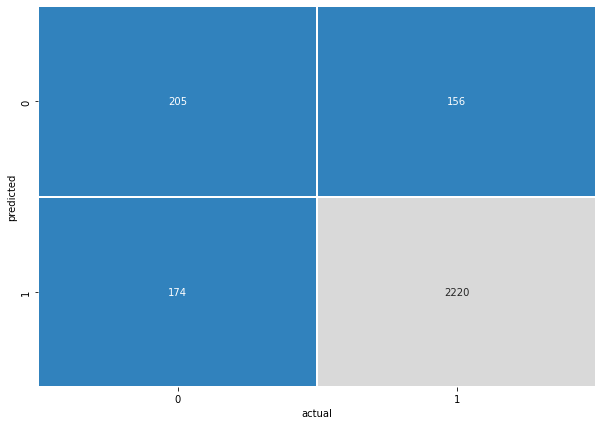

In [1215]:
plt.figure(figsize = (10,7))
sns.heatmap([[tp, fp],[fn, tn]], linewidths=.05, annot=True, cmap='tab20c', fmt='1', cbar=False)
plt.xlabel('actual')
plt.ylabel('predicted')

$accuracy = \frac{TP + TN}{TP+TN+FP+FN}$

In [1216]:
accuracy=float((tp+tn) /(results.count()))
f'accuracy: {accuracy}'

'accuracy: 0.8802177858439202'

$recall = \frac{TP}{TP+FN}$

In [1217]:
recall = float(tp)/(tp + fn)
f'recall {recall}'

'recall 0.5408970976253298'

$precision = \frac{TP}{TP + FP}$

In [1218]:
precision = float(tp) / (tp + fp)
f'precision: {precision}'

'precision: 0.5678670360110804'

In [1219]:
trainingSummary = log_reg.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

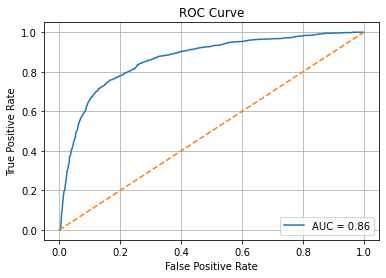

'Площадь под кривой: 0.8639564770082907'

In [1220]:
plt.plot(roc['FPR'],roc['TPR'], label='AUC = %0.2f' % trainingSummary.areaUnderROC)
plt.legend(loc='lower right')
plt.plot([0,1], ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()
f'Площадь под кривой: {trainingSummary.areaUnderROC}'

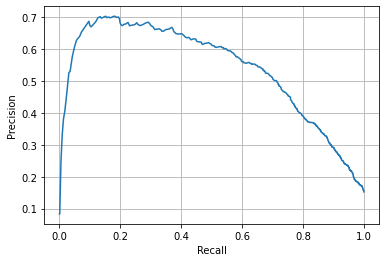

In [1221]:
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.show()

## Вывод: прикольно